<hr/>

# Introduction to Data Science
**Tamás Budavári** - budavari@jhu.edu <br/>

- Classification problems
- Naive Bayes Classifier
- Quadratic Discriminant Analysis

<hr/>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

<h1><font color="darkblue">Classification</font></h1>

- Based on a **training set** of labeled points, assign class labels to unknown vectors in the **query set**.  

> **Training set**
><br><br>
>$T = \big\{ (\boldsymbol{x}_i, C_i) \big\}_{i=1}^N$ where $x_i\in \mathbb{R}^d$ and $C_i$ is the known class membership 

> **Query set**
><br><br>
>$Q = \big\{ \boldsymbol{x}_j \big\}_{j=1}^M$ where $x_j\in \mathbb{R}^d$ 

> For example,
> blood test results ($\boldsymbol{x}$) and sick/healty ($C$) - we want to predict if a new patient is sick based on the available measurements

- Similar to regression but with discrete categories to classify into...

### Classification Methods

- $k$-NN
- Naive Bayes
- Linear Discriminant Analysis
- Logistic regression
- Decisions trees
- Random forests
- Support Vector Machines

### The Iris Dataset

We'll use this data set available in [scikit-learn](http://scikit-learn.org/stable/index.html), see [this](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) page for details

### Other examples

More [exercises](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#examples-using-sklearn-neighbors-kneighborsclassifier) are available at http://scikit-learn.org

### $k$ Nearest Neighbors



In [2]:
from sklearn import datasets
iris = datasets.load_iris()

In [3]:
[k for k in iris]

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [4]:
# unique known classes in training set
classes = np.unique(iris.target)
print ('There are %d classes:' % len(classes), classes)

There are 3 classes: [0 1 2]


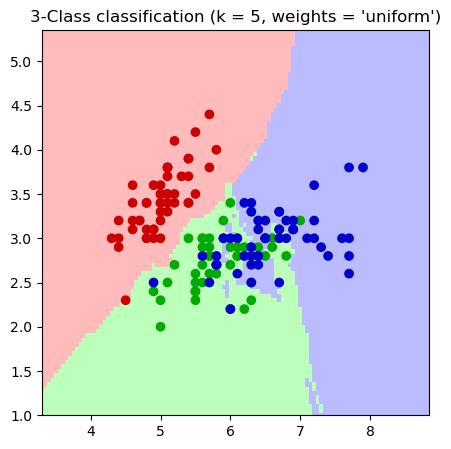

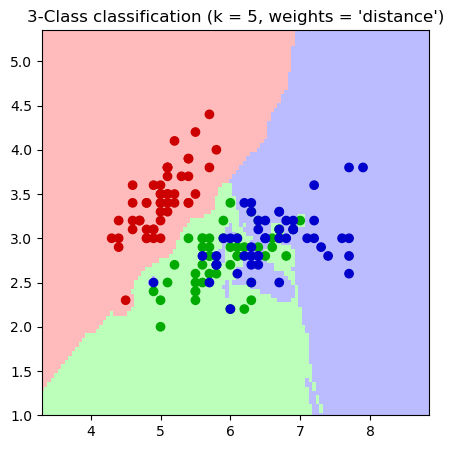

In [5]:
from sklearn import neighbors

# create color maps
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])
cmap_bold = ListedColormap(['#CC0000', '#00AA00', '#0000CC'])

n_neighbors = 5

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:,:2]  # we only take the first two features
y = iris.target

h = 0.05  # step size in the mesh

x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

for weights in ['uniform', 'distance']:
    
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)
    
    ZZ = clf.predict(grid)
    ZZ = ZZ.reshape(xx.shape) # 2-D grid layout

    # Plot the decision boundary. For that, we will assign a color to each grid point
    plt.figure(figsize=(5,5))
    plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, shading='nearest')
    
    # Plot also the training points
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

### Meaningful Distance?

- Need a distance function

> E.g., use Euclidean distance in $\mathbb{R}^d$

- Problem with different features and units

> In practice **centering** and **scaling** often helps <br/>
> Arguably, black art...


### Naive Bayes Classifier

- In general, we can use Bayes' rule (and the law of total probability) to infer discrete classes $C_k$ for a given $\boldsymbol{x}$ set of features

>$\displaystyle P(C_k \lvert\,\boldsymbol{x}) = \frac{\pi(C_k)\,{\cal{}L}_{\!\boldsymbol{x}}(C_k)}{Z} $ 


- Naively assuming the features are independent 

>$\displaystyle {\cal{}L}_{\!\boldsymbol{x}}(C_k) = \prod_{\alpha}^d p(x_{\alpha} \lvert C_k)$ 


### Naive Bayes: Learning

- Say for Gaussian likelihoods, we simply estimate the sample mean and variance of all features for each class $k$

>$\displaystyle p(x_{\alpha} \lvert C_k) = G(x_{\alpha};\mu_{k,\alpha}, \sigma^2_{k,\alpha})$

- We have to also pick some prior for the classes

> Using uniform or based on frequency of points in the training set?



### Naive Bayes: Estimation

- Look for maximum of the posterior


>$\displaystyle \hat{k} =  \mathrm{arg}\max_k \left[ \pi_k \prod_{\alpha}^d G(x_{\alpha};\mu_{k,\alpha}, \sigma^2_{k,\alpha})\right]$ 


In [6]:
# calculate feature means and variances for each class
param = dict()  # we save them in this dictionary
data = iris.data.copy()
for k in classes:
    members = (iris.target == k) # boolean array
    num = members.sum() # True:1, False:0
    prior = num / iris.target.size
    X = data[members,:] # slice out members
    mu = X.mean(axis=0) # calc mean
    X -= mu
    var = np.square(X).sum(axis=0) / (X.shape[0] - 1)
    param[k] = (num, prior, mu, var) # save results
    print (k, mu, var)

0 [5.006 3.428 1.462 0.246] [0.12424898 0.1436898  0.03015918 0.01110612]
1 [5.936 2.77  4.26  1.326] [0.26643265 0.09846939 0.22081633 0.03910612]
2 [6.588 2.974 5.552 2.026] [0.40434286 0.10400408 0.30458776 0.07543265]


In [7]:
# init predicted values
k_pred = -1 * np.ones(iris.target.size)

# evaluate posterior for each point and find maximum
for i in range(iris.target.size):
    pmax, kmax = -1, None   # initialize to nonsense values
    for k in param:
        num, prior, mu, var = param[k]
        diff = iris.data[i,:] - mu
        d2 = np.square(diff) / (2*var) 
        p = prior * np.exp(-d2.sum()) / np.sqrt(np.prod(2 * np.pi * var))
        if p > pmax:
            pmax = p
            kmax = k
    k_pred[i] = kmax

print("Number of mislabeled points out of a total %d points : %d"
      % (iris.target.size, (iris.target!=k_pred).sum()))

Number of mislabeled points out of a total 150 points : 6


In [8]:
# init predicted values
k_pred = -1 * np.ones(iris.target.size)

# evaluate posterior for each point and find maximum
for i in range(iris.target.size):
    pmax, kmax = -1, None   # initialize to nonsense values
    parr = np.zeros_like(classes, dtype=np.float64) # class probabilities
    for k in classes:
        num, prior, mu, var = param[k]
        diff = iris.data[i,:] - mu
        d2 = np.square(diff) / (2*var) 
        p = prior * np.exp(-d2.sum()) / np.sqrt(np.prod(2 * np.pi * var))
        parr[k] = p # save
        if p > pmax:
            pmax = p
            kmax = k
    print (i, parr / parr.sum()) # normalize
    k_pred[i] = kmax

print("Number of mislabeled points out of a total %d points : %d"
      % (iris.target.size, (iris.target!=k_pred).sum()))

0 [1.00000000e+00 2.98130936e-18 2.15237312e-25]
1 [1.00000000e+00 3.16931184e-17 6.93802994e-25]
2 [1.00000000e+00 2.36711261e-18 7.24095643e-26]
3 [1.00000000e+00 3.06960607e-17 8.69063581e-25]
4 [1.00000000e+00 1.01733735e-18 8.88579362e-26]
5 [1.00000000e+00 2.71773169e-14 4.34428540e-21]
6 [1.00000000e+00 2.32163910e-17 7.98827129e-25]
7 [1.00000000e+00 1.39075122e-17 8.16699477e-25]
8 [1.00000000e+00 1.99015585e-17 3.60646902e-25]
9 [1.00000000e+00 7.37893147e-18 3.61549223e-25]
10 [1.00000000e+00 9.39608901e-18 1.47462333e-24]
11 [1.00000000e+00 3.46196432e-17 2.09362749e-24]
12 [1.00000000e+00 2.80452047e-18 1.01019202e-25]
13 [1.00000000e+00 1.79903266e-19 6.06057778e-27]
14 [1.00000000e+00 5.53387950e-19 2.48503292e-25]
15 [1.00000000e+00 6.27386346e-17 4.50986372e-23]
16 [1.00000000e+00 1.10665843e-16 1.28241922e-23]
17 [1.00000000e+00 4.84177304e-17 2.35001131e-24]
18 [1.00000000e+00 1.12617475e-14 2.56717986e-21]
19 [1.00000000e+00 1.80851332e-17 1.96392412e-24]
20 [1.0000

In [9]:
# run sklearn's version - read up on differences if interested
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(iris.data, iris.target).predict(iris.data)

print("Number of mislabeled points out of a total %d points : %d"
      % (iris.target.size, (iris.target!=y_pred).sum()))

Number of mislabeled points out of a total 150 points : 6


In [10]:
# same results from both methods?
np.alltrue(k_pred==y_pred)

True

In [11]:
gnb.class_prior_

array([0.33333333, 0.33333333, 0.33333333])

In [12]:
gnb.var_

array([[0.121764, 0.140816, 0.029556, 0.010884],
       [0.261104, 0.0965  , 0.2164  , 0.038324],
       [0.396256, 0.101924, 0.298496, 0.073924]])

In [13]:
# class probabilities
gnb.predict_proba(iris.data)

array([[1.00000000e+000, 1.35784265e-018, 7.11283512e-026],
       [1.00000000e+000, 1.51480769e-017, 2.34820051e-025],
       [1.00000000e+000, 1.07304179e-018, 2.34026774e-026],
       [1.00000000e+000, 1.46619543e-017, 2.95492722e-025],
       [1.00000000e+000, 4.53291917e-019, 2.88389975e-026],
       [1.00000000e+000, 1.49094245e-014, 1.75752068e-021],
       [1.00000000e+000, 1.10262691e-017, 2.71144689e-025],
       [1.00000000e+000, 6.53644612e-018, 2.77336308e-025],
       [1.00000000e+000, 9.42227052e-018, 1.20443161e-025],
       [1.00000000e+000, 3.42348334e-018, 1.20750647e-025],
       [1.00000000e+000, 4.38090482e-018, 5.06830427e-025],
       [1.00000000e+000, 1.65766943e-017, 7.24748728e-025],
       [1.00000000e+000, 1.27573119e-018, 3.28718898e-026],
       [1.00000000e+000, 7.73742183e-020, 1.86207920e-027],
       [1.00000000e+000, 2.43526387e-019, 8.23627924e-026],
       [1.00000000e+000, 3.04074398e-017, 1.66211400e-023],
       [1.00000000e+000, 5.42610885e-017

#### Still cheating!!

### Pros and Cons

- Features are automatically treated correctly relative to each other

> For example, measuring similar things in different units? 1m vs 1mm
><br><br>
> The estimated mean and variance puts them on a meaningful scale

- Independence is a strong assumption and for no good reason

> Actually... it helps with the computational cost!

### Exercise: Gaussian Naive Bayes

- Use the provided [training](Class-Train.csv) and [query](Class-Query.csv) sets to perform classification

> **Training** set consists of 3 columns of ($x_i$, $y_i$, $C_i$)

> **Query** set only has 2 columns of ($x_i$, $y_i$)


### Full Covariance Matrix

- Estimate the full covariance matrix for the classes

>$\displaystyle {\cal{}L}_{\!\boldsymbol{x}}(C_k) =  G(\boldsymbol{x};\mu_k, \Sigma_k)$
><br><br>
> Handles correlated features well

- Consider binary problem with 2 classes

> Taking the negative logarithm of the likelihoods we compare
><br><br>
>$\displaystyle (\boldsymbol{x}\!-\!\boldsymbol{\mu}_1)^T\,\Sigma_1^{-1}(\boldsymbol{x}\!-\!\boldsymbol{\mu}_1) + \ln\,\lvert\Sigma_1\lvert$ vs.
><br><br>
>$\displaystyle (\boldsymbol{x}\!-\!\boldsymbol{\mu}_2)^T\,\Sigma_2^{-1}(\boldsymbol{x}\!-\!\boldsymbol{\mu}_2) + \ln\,\lvert\Sigma_2\lvert$
><br><br>
> If the difference is lower than a threshold, we classify it accordingly

- This is called **Quadratic Discriminant Analysis**

### Same Covariance Matrix

- When $\Sigma_1=\Sigma_2=\Sigma$, the quadratic terms cancel from the difference
 
>$\displaystyle (x\!-\!\mu_1)^T\,\Sigma^{-1}(x\!-\!\mu_1) $ 
>$\displaystyle -\ (x\!-\!\mu_2)^T\,\Sigma^{-1}(x\!-\!\mu_2) $

- Hence this is called **Linear Discriminant Analysis**

> Fewer parameters to estimate during the learning process
><br><br>
> Good, if we don't have enough data, for example...
><br><br>
> Think linear vs quadratic fitting and how you decide between those

### Exercise: QDA and LDA

- Use the provided [training](Class-Train.csv) and [query](Class-Query.csv) sets to perform classification

> **Training** set consists of 3 columns of ($x_i$, $y_i$, $C_i$)
><br><br>
> **Query** set only has 2 columns of ($x_i$, $y_i$)



### Unhomework

- Visualize the results in the 2D features space
- Make these simple codes run faster by getting rid of the `for` loops, etc.
